# Implement Gaussian Process through Earth-Moon evolution data

by *Niels J. de Winter* **n.j.de.winter@vu.nl**

### Inspiration by the following references:
* https://hendersontrent.github.io/posts/2024/05/gaussian-process-time-series/
* https://distill.pub/2019/visual-exploration-gaussian-processes/
* https://www.cs.toronto.edu/~duvenaud/cookbook/

### Overview of steps:
* Load or define dataset of length of day values against geological age, including uncertainties
* Define composite kernel, consisting of Radial Base Function, Linear and Noise components
* Include error in Y-direction into noise component
* Include error in X-direction into RBF kernel using closed form errors-in-variables solution by [Girard, A., Rasmussen, C. E., Quiñonero-Candela, J., & Murray-Smith, R. (2003). Gaussian Process Priors with Uncertain Inputs – Application to Multiple-Step Ahead Time Series Forecasting. In Advances in Neural Information Processing Systems (NIPS 15).]{https://mlg.eng.cam.ac.uk/pub/pdf/GirRasQuiMur03.pdf}
* Optimize hyperparameters using Negative Log Marginal Likelihood
* Sample from optimized posterior Gaussian Process kernel and only include monotonous Earth-Moon distance evolution trajectories

In [14]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import cholesky, cho_solve, solve_triangular
from numpy.linalg import inv, solve
# from scipy.linalg import cho_solve
from scipy.optimize import minimize, LinearConstraint
from scipy.interpolate import interp1d

# Input data

## Input manually estimated data based on Williams et al. (2000)

In [15]:
# Manually estimated data with rough error bars from the Figure 2 in Williams et al. (2000)
data = [
    {"Age (Ma)": 620, "Age error": 30, "Days/year": 400, "Days/year error": 10, "Hours/day": 22.0, "Hours/day error": 0.4, "Data type": "Elatina–Reynella"},
    {"Age (Ma)": 600, "Age error": 25, "Days/year": 410, "Days/year error": 10, "Hours/day": 21.4, "Hours/day error": 0.3, "Data type": "Stromatolites, max"},
    {"Age (Ma)": 550, "Age error": 20, "Days/year": 417, "Days/year error": 5, "Hours/day": 21.0, "Hours/day error": 0.2, "Data type": "Stromatolites, mean"},
    {"Age (Ma)": 500, "Age error": 15, "Days/year": 415, "Days/year error": 5, "Hours/day": 21.1, "Hours/day error": 0.2, "Data type": "Brachiopods, max"},
    {"Age (Ma)": 450, "Age error": 10, "Days/year": 410, "Days/year error": 5, "Hours/day": 21.3, "Hours/day error": 0.2, "Data type": "Bivalves, mean"},
    {"Age (Ma)": 400, "Age error": 5, "Days/year": 400, "Days/year error": 5, "Hours/day": 22.0, "Hours/day error": 0.2, "Data type": "Corals, max"},
    {"Age (Ma)": 380, "Age error": 3, "Days/year": 395, "Days/year error": 10, "Hours/day": 22.2, "Hours/day error": 0.3, "Data type": "Corals, mean"},
    {"Age (Ma)": 300, "Age error": 2, "Days/year": 385, "Days/year error": 10, "Hours/day": 22.6, "Hours/day error": 0.3, "Data type": "Corals, mean"},
    {"Age (Ma)": 250, "Age error": 1, "Days/year": 375, "Days/year error": 10, "Hours/day": 23.3, "Hours/day error": 0.3, "Data type": "Brachiopods, max"},
    {"Age (Ma)": 150, "Age error": 1, "Days/year": 370, "Days/year error": 10, "Hours/day": 23.5, "Hours/day error": 0.3, "Data type": "Brachiopods, max"},
    {"Age (Ma)": 0, "Age error": 0, "Days/year": 365.25, "Days/year error": 0, "Hours/day": 24.0, "Hours/day error": 0, "Data type": "Modern value"},
]

df = pd.DataFrame(data)
df.head()

,Age (Ma),Age error,Days/year,Days/year error,Hours/day,Hours/day error,Data type
0,620,30,400.0,10,22.0,0.4,Elatina–Reynella
1,600,25,410.0,10,21.4,0.3,"Stromatolites, max"
2,550,20,417.0,5,21.0,0.2,"Stromatolites, mean"
3,500,15,415.0,5,21.1,0.2,"Brachiopods, max"
4,450,10,410.0,5,21.3,0.2,"Bivalves, mean"


# Define kernel

## Start with Exponentiated Quadratic Kernel (= Radial Basis Function)

### Define Exponentiated quadratic kernel (Radial Basis Function)

In [16]:
# Define Radial Basis Function kernel function
def rbf_kernel(X1, X2, lengthscale=1.0, variance=1.0):
    """Radial Basis Function (RBF) kernel"""
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + \
             np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return variance * np.exp(-0.5 / lengthscale**2 * sqdist)

### Update RBF kernel to contain x-errors

In [17]:
# Define Radial Basis Function kernel function
def rbf_kernel_with_xerr(X1, X2, xerr1=None, xerr2=None, variance=1.0, lengthscale=1.0):
    """
    RBF kernel that accounts for input uncertainties.
    X1, X2: arrays of shape (n,1)
    xerr1, xerr2: arrays of std devs for inputs
    """
    X1 = np.atleast_2d(X1).reshape(-1, 1) # Ensure inputs are 2D column vectors
    X2 = np.atleast_2d(X2).reshape(-1, 1) # Ensure inputs are 2D column vectors

    # Catch case where no input errors are provided
    if xerr1 is None:
        xerr1 = np.zeros_like(X1)
    if xerr2 is None:
        xerr2 = np.zeros_like(X2)

    # Compute the modified kernel
    s1 = xerr1.reshape(-1, 1)**2 # Reshape to column vector
    s2 = xerr2.reshape(1, -1)**2 # Reshape to row vector
    denom = lengthscale**2 + s1 + s2 # Denominator term including input uncertainties

    sqdist = (X1 - X2.T)**2 # Squared distance between points
    return variance * np.sqrt(lengthscale**2 / denom) * np.exp(-sqdist / (2 * denom)) # Exponent term with modified denominator

## Define linear kernel

In [18]:
# Define linear Kernel function
def linear_kernel(X1, X2, variance=1.0, variance_b=1.0, c=0.0):
    """Linear kernel: k(x, x') = variance * (x-c)(x'-c) + variance_b"""
    X1 = np.atleast_2d(X1).reshape(-1, 1) # Ensure inputs are 2D column vectors
    X2 = np.atleast_2d(X2).reshape(-1, 1) # Ensure inputs are 2D column vectors
    return variance * (X1 - c) @ (X2 - c).T + variance_b # Linear kernel formula

## Define white noise kernel

In [19]:
def white_noise_kernel(X1, X2, noise_variance=1e-6):
    if np.array_equal(X1, X2):
        return noise_variance * np.eye(len(X1))
    else:
        return np.zeros((len(X1), len(X2)))

## Define composite kernel

In [20]:
## Define function for composite kernel, combining RBF and Linear kernels
def combined_kernel(X1, X2, xerr1 = None, xerr2 = None, sigma1 = 1, sigma2 = 1, sigmab = 1, lengthscale=1.0, c=0.0, noise = 1e-6):
    """ Combined kernel: sum of Radial Basis Function with Linear kernels
        Parameters:
    sigma1 (float): Variance of the RBF kernel.
    sigma2 (float): Variance of the Linear kernel.
    sigmab (float): Bias (slope) variance of the Linear kernel.
    lengthscale (float): Lengthscale of the RBF kernel.
    c (float): Offset for the Linear kernel.
    
    Returns:
    numpy.ndarray: Combined kernel matrix.
    """
    return (rbf_kernel(X1, X2, xerr1, xerr2, lengthscale=lengthscale, variance=sigma1) +
            linear_kernel(X1, X2, variance=sigma2, variance_b=sigmab, c=c) +
            white_noise_kernel(X1, X2, noise_variance=noise)
    )

# Gaussian Process function

In [21]:
# Function to calculate posterior mean vector and covariance matrix
def gp_posterior_with_xy_errors(x_train, x_err, y_train, y_err, x_test, kernel, noise_variance = 1e-6, params = {"sigma1": 1, "sigma2": 1, "sigmab": 1, "lengthscale": 1.0, "c": 0.0}):
    """
    Calculate the posterior mean vector and covariance matrix for Gaussian Process regression.
    
    Parameters:
    x_train (array-like): Training input data points.
    y_train (array-like): Training output data points.
    y_err (array-like): Observation errors for the training output data points.
    x_test (array-like): Test input data points where predictions are to be made.
    kernel (function): Kernel function to compute the covariance matrix.
    noise_variance (float): Variance of the observation noise (sigma of the noise kernel, default = 10^-6).
    params (dict): Hyperparameters for the kernel functions.
    
    Returns:
    tuple: Input data, posterior mean vector and covariance matrix for the test points.
    """
    # Compute covariance matrices
    K = kernel(x_train, x_train, xerr1 = x_err, xerr2 = x_err, noise = noise_variance, **params) + np.diag(y_err**2) # Prior covariance matrix with noise term
    K_s = kernel(x_train, x_test, xerr1 = x_err, xerr2 = x_err, noise = noise_variance, **params) # Cross-covariance between training and test points
    K_ss = kernel(x_test, x_test, xerr1 = x_err, xerr2 = x_err, noise = noise_variance, **params) # Prior covariance matrix for test points

    # Compute the Cholesky decomposition
    L = cholesky(K, lower=True)

    # Solve for alpha to allow efficient computation of the posterior mean
    alpha = cho_solve((L, True), y_train) # alpha is equal to the training outputs scaled by the inverse of the training covariance

    # Compute the posterior mean
    mu_post = K_s.T @ alpha

    # Compute the posterior covariance
    v = solve_triangular(L, K_s, lower=True) # Solve for v using triangular solve for better numerical stability. v is equal to the covariance between training and test points scaled by the inverse of the training covariance
    cov_post = K_ss - v.T @ v # Posterior covariance is equal to the prior covariance minus the uncertainty reduction

    return mu_post, cov_post

### TEST: Run the Gaussian Process function after normalization and plot the resulting posterior means +/- covariance stds

In [23]:
# 1. Prepare data
X_train = df["Age (Ma)"].values.reshape(-1, 1).astype(float)
X_error = df["Age error"].values.reshape(-1, 1).astype(float)
Y_train = df["Days/year"].values.astype(float)
Y_error = df["Days/year error"].values.astype(float)
X_test = np.linspace(0, 650, 500).reshape(-1, 1) # Test points

# Normalize input
X_mean = X_train.mean()
X_std = X_train.std()
X_train_norm = (X_train - X_mean) / X_std
X_error_norm = X_error / X_std
X_test_norm = (X_test - X_mean) / X_std
Y_mean = Y_train.mean()
Y_std = Y_train.std()
Y_train_norm = (Y_train - Y_mean) / Y_std
Y_error_norm = Y_error / Y_std

# Get posterior mean and covariance
X_train_norm, X_test_norm, Y_train_norm, mu_post, cov_post = gp_posterior_with_xy_errors(
    X_train_norm,
    X_error_norm,
    Y_train_norm,
    Y_error_norm,
    X_test_norm,
    combined_kernel,
    noise_variance = 0.1,
    params = {
        "sigma1": 1,
        "sigma2": 0.1,
        "sigmab": -0.3,
        "lengthscale": 1,
        "c": 0
    }
)

# Rescale back to original units
X_train_rescaled, X_test_rescaled = X_train_norm * X_std + X_mean, X_test_norm * X_std + X_mean
Y_train_rescaled, mu_post_rescaled = Y_train_norm * Y_std + Y_mean, mu_post * Y_std + Y_mean
cov_post_rescaled = cov_post * (Y_std ** 2)

# Plot mupost with 95% confidence interval
plt.figure(figsize=(10, 6))
plt.fill_between(X_test_rescaled.flatten(), 
                 mu_post_rescaled - 1.96 * np.sqrt(np.diag(cov_post_rescaled)), 
                 mu_post_rescaled + 1.96 * np.sqrt(np.diag(cov_post_rescaled)), 
                 color='lightgray', label='95% Confidence Interval')
plt.plot(X_test_rescaled, mu_post_rescaled, 'r-', label='Posterior Mean (untrained)')
plt.errorbar(X_train_rescaled, Y_train_rescaled, yerr=Y_error, fmt='o', color='blue', capsize=5, label='Training Data')
plt.gca().invert_xaxis()
plt.xlim(650, -50)
plt.xlabel("Age (Ma)")
plt.ylabel("Days per Year")
plt.title("Earth's Rotation Over Geologic Time")
plt.grid(True)
plt.legend()
plt.tight_layout()

TypeError: rbf_kernel() got multiple values for argument 'lengthscale'

# Optimize hyperparameters of combined kernel using Log-Marginal Likelihood
### NOTE: Should also ude gradient for this, but derivation is more complicated

In [12]:
def negative_log_marginal_likelihood(params, X_train, X_train_err, Y_train, Y_train_err, kernel):
    # Unpack hyperparameters (enforce positivity with exp for some parameters)
    sigma1 = np.exp(params[0])          # RBF variance
    sigma2 = np.exp(params[1])          # Linear variance
    sigmab = params[2]                  # Bias term (can be negative, leave as is)
    lengthscale = np.exp(params[3])     # RBF lengthscale
    c = params[4]                       # Linear offset (can be negative, leave as is)
    noise_variance = np.exp(params[5])  # Noise variance
    
    # Compute prior covariance matrix and add noise based on observation errors
    K = kernel(X_train, X_train, xerr1 = X_train_err, xerr2 = X_train_err, sigma1=sigma1, sigma2=sigma2, sigmab=sigmab,
               lengthscale=lengthscale, c=c, noise = noise_variance) + np.diag(Y_train_err**2)  # Add observation noise

    # Cholesky decomposition
    try:
        L = cholesky(K, lower=True)
    except np.linalg.LinAlgError:
        return np.inf  # Numerical issue: return large value if K is not positive definite
    
    # Compute log marginal likelihood
    alpha = cho_solve((L, True), Y_train)
    logdet = 2.0 * np.sum(np.log(np.diag(L)))
    mll = -0.5 * Y_train @ alpha - 0.5 * logdet - 0.5 * len(X_train) * np.log(2 * np.pi)
    return -mll  # return negative log marginal likelihood

## Try to find the optimal combination of kernel hyperparameters by minimizing the negative log-marginal likelihood

In [13]:
# 1. Prepare data
X_train = df["Age (Ma)"].values.reshape(-1, 1).astype(float)
Y_train = df["Days/year"].values.astype(float)
Y_error = df["Days/year error"].values.astype(float)
X_error = df["Age error"].values.reshape(-1, 1).astype(float)
X_test = np.linspace(0, 650, 500).reshape(-1, 1) # Test points

# Normalize input
X_mean = X_train.mean()
X_std = X_train.std()
X_train_norm = (X_train - X_mean) / X_std
X_error_norm = X_error / X_std
X_test_norm = (X_test - X_mean) / X_std
Y_mean = Y_train.mean()
Y_std = Y_train.std()
Y_train_norm = (Y_train - Y_mean) / Y_std
Y_error_norm = Y_error / Y_std

# Initial guess (log space for positivity)
x0 = [np.log(1), np.log(0.1), -0.3, np.log(1), 0, np.log(1e-8)]  # adjust initial values to best guesses

res = minimize(
    negative_log_marginal_likelihood, 
    x0=x0, 
    args=(X_train_norm, X_error_norm, Y_train_norm, Y_error_norm, combined_kernel),
    method="L-BFGS-B"
)

print("Optimization success:", res.success)
print("Optimal parameters:", res.x)

TypeError: rbf_kernel() got multiple values for argument 'lengthscale'

### Run the Gaussian Process function with optimized hyperparameters plot the resulting posterior means +/- covariance stds

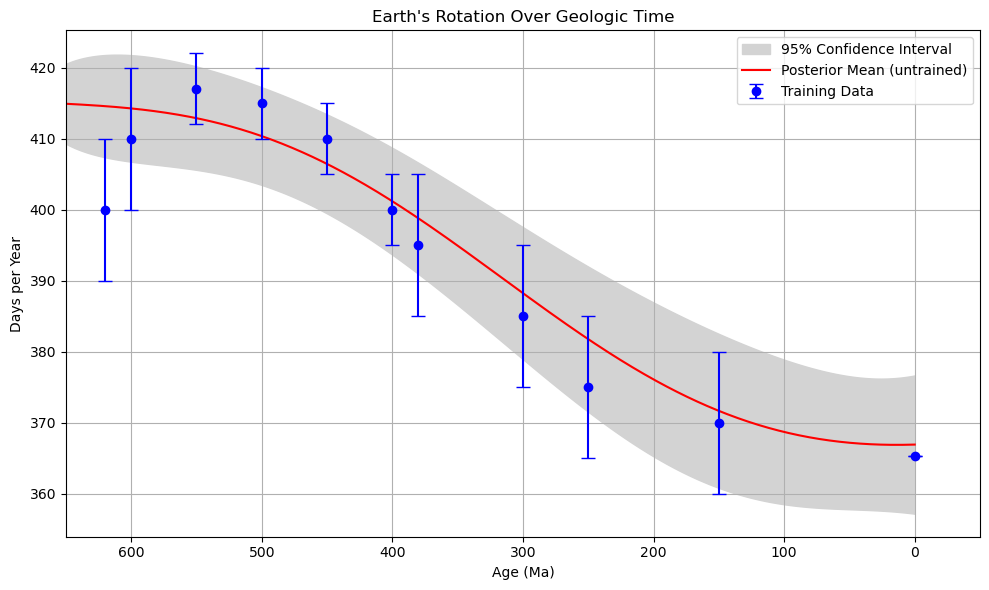

In [ ]:
# 1. Prepare data
X_train = df["Age (Ma)"].values.reshape(-1, 1).astype(float)
Y_train = df["Days/year"].values.astype(float)
Y_error = df["Days/year error"].values.astype(float)
X_test = np.linspace(0, 650, 500).reshape(-1, 1) # Test points

# Normalize input
X_mean = X_train.mean()
X_std = X_train.std()
X_train_norm = (X_train - X_mean) / X_std
X_test_norm = (X_test - X_mean) / X_std
Y_mean = Y_train.mean()
Y_std = Y_train.std()
Y_train_norm = (Y_train - Y_mean) / Y_std
Y_error_norm = Y_error / Y_std

# Prepare optimal parameters
opt_params = {
    "sigma1": np.exp(res.x[0]),
    "sigma2": np.exp(res.x[1]),
    "sigmab": res.x[2],
    "lengthscale": np.exp(res.x[3]),
    "c": res.x[4]
}

# Get posterior mean and covariance
mu_post, cov_post = gp_posterior_with_errors(
    X_train_norm,
    Y_train_norm,
    Y_error_norm,
    X_test_norm,
    combined_kernel,
    noise_variance = 0.1,
    params = opt_params
)

# Rescale back to original units
mu_post_rescaled = mu_post * Y_std + Y_mean
cov_post_rescaled = cov_post * (Y_std ** 2)

# Plot mupost with 95% confidence interval
plt.figure(figsize=(10, 6))
plt.fill_between(X_test_rescaled.flatten(), 
                 mu_post_rescaled - 1.96 * np.sqrt(np.diag(cov_post_rescaled)), 
                 mu_post_rescaled + 1.96 * np.sqrt(np.diag(cov_post_rescaled)), 
                 color='lightgray', label='95% Confidence Interval')
plt.plot(X_test_rescaled, mu_post_rescaled, 'r-', label='Posterior Mean (untrained)')
plt.errorbar(X_train_rescaled, Y_train_rescaled, yerr=Y_error, fmt='o', color='blue', capsize=5, label='Training Data')
plt.gca().invert_xaxis()
plt.xlim(650, -50)
plt.xlabel("Age (Ma)")
plt.ylabel("Days per Year")
plt.title("Earth's Rotation Over Geologic Time")
plt.grid(True)
plt.legend()
plt.tight_layout()

### Define function to draw from Gaussian Process posterior

In [ ]:
# Define function to draw and plot from Gaussian Process posterior
def sample_from_GP_posterior(
        cov_post,
        mu_post,
        X,
        X_in,
        Y_in,
        k = 5,
        X_error = None,
        Y_error = None
):
    """
    Sample from the posterior distribution of a Gaussian Process and plot the results.
    
    Parameters:
    cov_post (array-like): Posterior covariance matrix.
    mu_post (array-like): Posterior mean vector.
    X (array-like): Input data points.
    X_in (array-like): Input training data points.
    Y_in (array-like): Output training data points.
    X_error (array-like): Errors in the input training data points.
    Y_error (array-like): Errors in the output training data points.
    k (int): Number of realizations to draw.
    
    Returns:
    None (plot)
    """
    # Prepare mean vector if mu = 0
    if mu_post is None:
        mu_post = np.zeros(cov_post.shape[0])
    
    # Produce dynamic column names, draw from multivariate normal distribution, and convert to DataFrame
    thenames = [f"Sample {i+1}" for i in range(k)] # Dynamic column names
    samples = np.random.multivariate_normal(mu_post, cov_post, size=k).transpose() # Draw samples from the posterior distribution
    df_samples = pd.DataFrame(samples, columns=thenames) # Convert to DataFrame
 
    # Add the input data points as a new column
    df_samples['Age (Ma)'] = X.flatten()
    # return(df_samples)

    # Plot the sampled points
    plt.figure(figsize=(10, 6))
    for i in range(k):
        plt.plot(df_samples['Age (Ma)'], df_samples[thenames[i]], label=f'Sample {i+1}')
    plt.errorbar(X_in, Y_in, xerr=X_error, yerr=Y_error, fmt='o', color='black', capsize=5, label='Training Data')
    plt.gca().invert_xaxis()
    plt.xlabel('Age (Ma)')
    plt.ylabel('Sampled Values')
    plt.title('Samples from Gaussian Process Posterior')


### TEST: Draw from normalized GP posterior

C:\Users\nwi213\AppData\Local\Temp\ipykernel_22752\4239086956.py:34: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mu_post, cov_post, size=k).transpose() # Draw samples from the posterior distribution


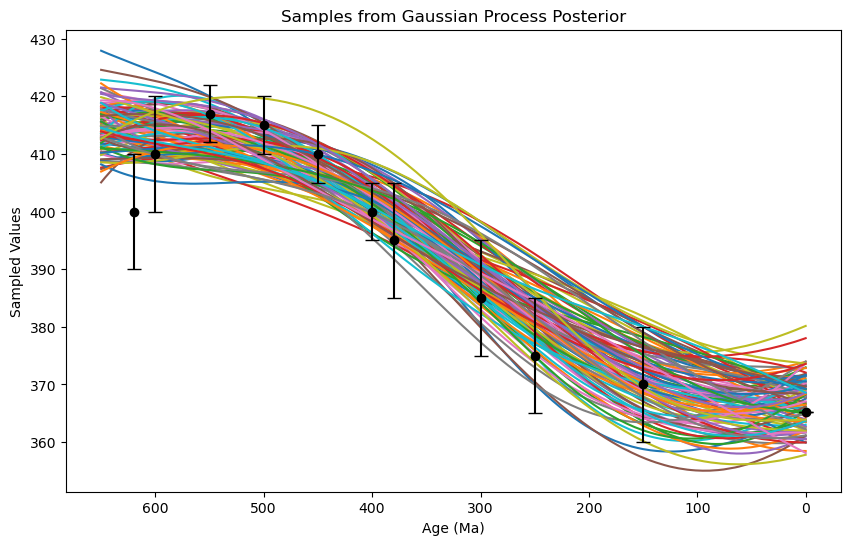

In [ ]:
# Plot 10 draws from the posterior
sample_from_GP_posterior(cov_post_rescaled, mu_post_rescaled, X = X_test_rescaled, X_in = X_train_rescaled, Y_in = Y_train_rescaled, Y_error = df["Days/year error"].values.astype(float), k = 100)